In [1]:
## importing the libraries and models

import os, pickle
import numpy as np
from tqdm.notebook import tqdm

# models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# input directory
base_dir = "C:/Users/HP/Desktop/Study Material/AI_Project/Image_Captioning/Data"

# main working directory or where files/output will be stored
working_dir = "C:/Users/HP/Desktop/Study Material/AI_Project/Image_Captioning"

# Image Feature Extraction

In [3]:
# loading the VGG16 model
model = VGG16()

# restructuring the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

# summarizing the model
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [4]:
# extracting the features from the images in dataset

features = {}
directory = os.path.join(base_dir, "Images")

# now iterating through images
for img_name in tqdm(os.listdir(directory)):
    # loading the images from the file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # now converting the image pixels into the numpy array
    image = img_to_array(image)
    # now reshaping the data for model to extract the features
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # now preparing the image for the model. In short preprocessing the image for VGG16
    image = preprocess_input(image)
    # now extracting the features from the images
    feature = model.predict(image, verbose = 0)
    # getting the image Id
    image_id = img_name.split('.')[0]
    # now storign the features that are extracted
    features[image_id] = feature
    
    # it will extract the features of all the images presented in the dataset.

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
# now storing the extracted features into pickle
pickle.dump(features, open(os.path.join(working_dir, "features.pkl"), "wb"))

In [5]:
# now loading the features from pickle
with open(os.path.join(working_dir, "features.pkl"), "rb") as f:
    features = pickle.load(f)

# Load the Captions

In [6]:
with open(os.path.join(base_dir, "captions.txt"), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# now creating the mapping of images and captions
mapping = {}
# processesing the lines
for line in tqdm(captions_doc.split('\n')):
    # spliting the individual line to obtain the image_id and captions
    tokens = line.split(',')
    if len(line) < 2:
        continue
    # loading the image_id and captions into their respective variables
    image_id, caption = tokens[0], tokens[1:]
    # removing the extension from image_id
    image_id = image_id.split('.')[0]
    # now converting the captions list into string
    caption = " ".join(caption)
    # creating the list of needed
    if image_id not in mapping:
        mapping[image_id] = []
    # storing the captions
    mapping[image_id].append(caption) 

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
# now checking the number of images we have
len(mapping)

8091

In [9]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

# Preprocessing of Text Data

In [10]:
def clear(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):  # as we know that 1 image may consist of multiple captions, 
        # Here we will be taking 1 caption at a time
            caption = captions[i]
            # now the preprocessing 
            # converting to the lower case
            caption = caption.lower()
            # removing every numerical value, special characters, leaving only alphabets
            caption = caption.replace('[^A-Za-z]', ' ') 
            # deleting the additional spaces
            caption = caption.replace('\s+', ' ')
            # adding start and end tags to the caption
            ## it will be helpful for the model, when to start and when to stop
            # also we will be removing the words wil less characters from the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            # replacing the caption at the corresponding index
            captions[i] = caption

In [11]:
# before the preprocessing of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# now preprocessing the text
clear(mapping)

In [13]:
# after the preprocessing of the text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
# now we will be creating a tokenizer and get the vocab size

# we will be storing the captions in an single list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
# checking the lenght of the allall_captions list
len(all_captions)

40455

In [16]:
# let us see the first 10 captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# now tokenizing the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 # word_index gives us the number of unique words

In [18]:
# now we will be checking the lenght of the vocabulary
vocab_size

8485

In [19]:
# now we will be checking the caption with maximum lenght
max_lenght = max(len(caption.split()) for caption in all_captions)
max_lenght

35

# Splitting the data for Training and Testing

In [20]:
image_ids = list(mapping.keys())
# splitting the data 
# 90 % of data for training and 10% for testing
split = int(len(image_ids) * 0.90)

In [21]:
# checking the data in split
split

7281

In [22]:
# training Data
train = image_ids[:split]

# testing data
test = image_ids[split:]

In [23]:
# now we will be creating a data generator in order to fetch the images and captions in batch with a specified batch size 

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation 

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_lenght,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_lenght, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 1179s 5s/step - loss: 2.1900


In [28]:
# save the model
model.save(working_dir+'/best_model.h5')

C:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generate Captions for the Image

In [25]:
# 1st we will conver the id's into words
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# now generating the caption for the image

# def predict_caption(model, image, tokenizer, max_lenght):
#     # start tag for the generation proccess
#     in_text = 'startseq '
#     # itaerating over the max_lenght of the sequence, during the training we had max_lenght = 35
#     for i in range(max_lenght):
#         # 1st we will convert the sequence('<startseq') into integer
#         # encoding the input sequence
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         # now padding the sequences
#         sequence = pad_sequences([sequence], max_lenght)
#         # predict next word
#         yhat = model.predict([image, sequence], verbose=0)
#         # it will give us the index of higher probability
#         yhat = np.argmax(yhat)
#         # now converting the index to word
#         word = index_to_word(yhat, tokenizer)
#         # stop if word in not found
#         if word is None:
#             break
#         # append word as input for generating the next word
#         in_text = " " + word
#         # stop if we reach to end tag
#         if word == ' endseq':
#             break
#         return in_text
from keras.models import load_model

# Load the saved model
saved_model = load_model(working_dir + '/best_model.h5')

def predict_caption(model, image, tokenizer, max_lenght):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_lenght):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_lenght)
        # predict next word
        yhat = saved_model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [38]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_lenght) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.526440
BLEU-2: 0.304772


In [39]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_lenght)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the dirt pavement endseq


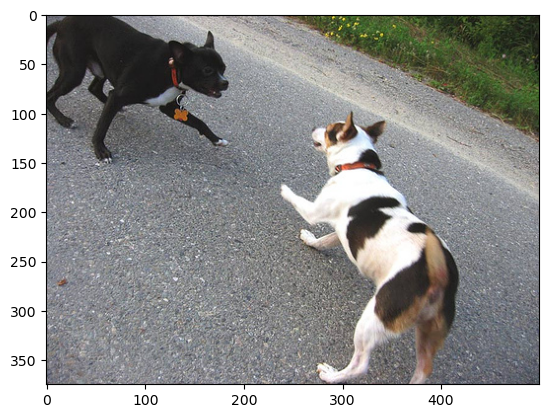

In [40]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq two little kids are sitting in the grass with fingerpaints in the background endseq


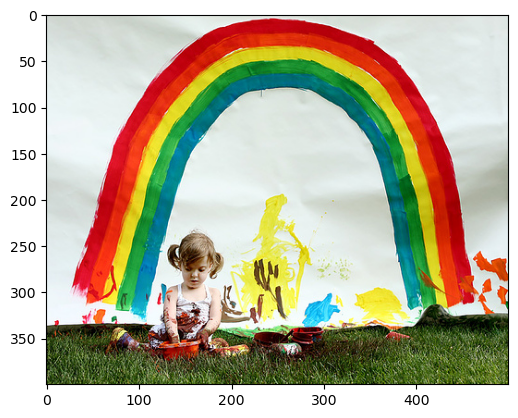

In [41]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq the little girl is sitting on the stairs endseq


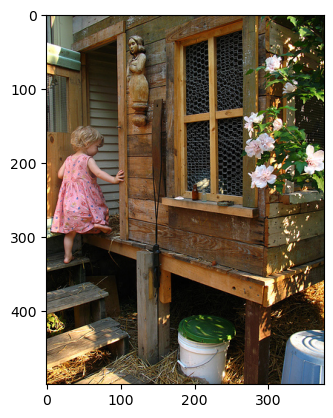

In [42]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people are displaying pictures in the snow endseq


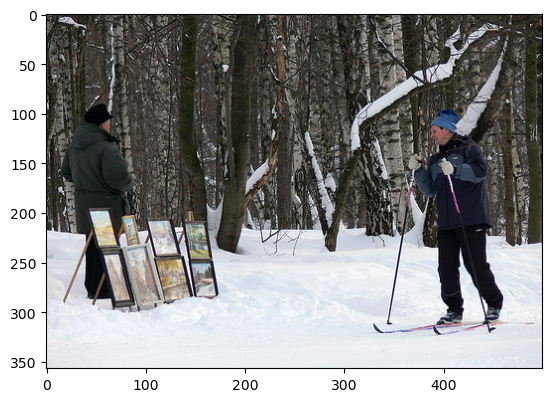

In [43]:
generate_caption("101669240_b2d3e7f17b.jpg")